# Neural Networks

ECON526

Paul Schrimpf (University of British Columbia)

# Introduction

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

## Neural Networks

-   Flexible function approximation & regression
-   Automated feature engineering
-   Exceptional performance on high dimensional data with low noise
    -   Text
    -   Images
    -   Audio
    -   Video

## Single Layer Perceptron

-   $x_i \in \R^d$, want to approximate some $f: \R^d \to \R$
-   Approximate by $$
    \begin{align*}
    f(x_i; \mathbf{w},\mathbf{b}) =
    \psi_1 \left( \sum_{u=1}^m w_{u,1} \psi_0( x_i'w_{u,0} + b_{u,0}) + b_{u,1} \right)
    \end{align*}
    $$ where
    -   Weights: $w_{u,1} \in \R$, $w_{u,0} \in \R^d$
    -   Biases: $b_{u,1}, b_{u,0} \in \R$
    -   Activation functions $\psi_1, \psi_0: \R \to \R$
    -   Width: $m$

## Activation functions

/tmp/ipykernel_681713/2445902844.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


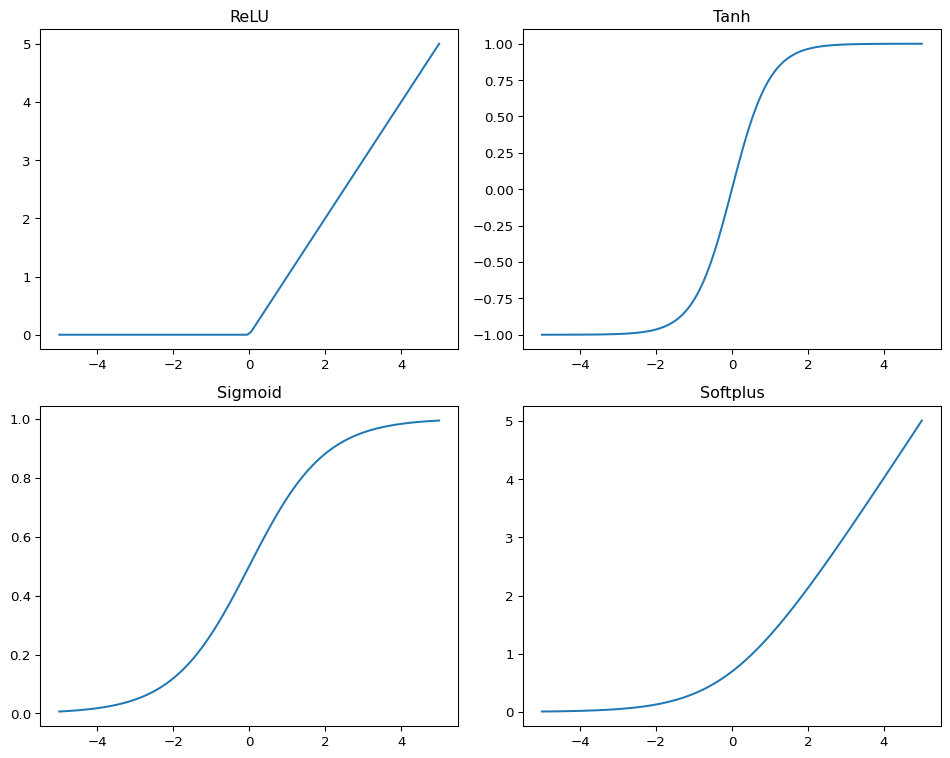

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
# plot 4 activation functions
x = torch.linspace(-5, 5, 100)
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()
ax[0].plot(x, nn.ReLU()(x))
ax[0].set_title("ReLU")
ax[1].plot(x, nn.Tanh()(x))
ax[1].set_title("Tanh")
ax[2].plot(x, nn.Sigmoid()(x))
ax[2].set_title("Sigmoid")
ax[3].plot(x, nn.Softplus()(x))
ax[3].set_title("Softplus")
fig.tight_layout()
fig.show()

## Single Layer Perceptron

In [2]:
import torch.nn as nn
import torch
class SingleLayerPerceptron(nn.Module):
    def __init__(self, d, m, activation=nn.ReLU()):
        super().__init__()
        self.d = d
        self.m = m
        self.activation = activation
        self.w0 = nn.Parameter(torch.randn(d, m))
        self.b0 = nn.Parameter(torch.randn(m))
        self.w1 = nn.Parameter(torch.randn(m))
        self.b1 = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.activation(x @ self.w0 + self.b0) @ self.w1 + self.b1

## Regression

-   Data $\{y_i, x_i\}_{i=1}^n$, $x_i \in \R^d$, $y_i \in \R$
-   Least squares: $$
    \hat{\mathbf{w}}, \hat{\mathbf{b}} \in \argmin_{\mathbf{w},\mathbf{b}} \underbrace{\frac{1}{n} \sum_{i=1}^n \left(y_i - f(x_i; \mathbf{w},\mathbf{b}) \right)^2}_{\text{loss function}}
    $$
-   Hard to find global minimum:
    -   Loss not convex
    -   Parameters very high dimensional

## Gradient Descent

-   Find approximate minimum instead $$
    \overbrace{\hat{\theta}}^{\hat{\mathbf{w}}, \hat{\mathbf{b}}} \approx \argmin_{\theta} \ell(y, f(x;\theta))
    $$
-   Start with random $\theta_1$
-   Repeatedly update: $$
    \theta_{i+1} = \theta_i - \gamma \underbrace{\nabla \ell(y,f(;\theta))}_{\text{gradient}}
    $$
-   Continue until loss stops improving
    -   Optionally modify $\gamma$ based on progress

## Computing Gradients

-   Automatic differentiation: automatically use chainrule on each step
    of computation
-   E.g. $\ell(\theta) = f(g(h(\theta)))$
    -   $\ell : \R^p \to \R$, $h: \R^p \to \R^q$, $g: \R^q \to \R^j$,
        $f: \R^j \to \R$ $$
        \left(\nabla \ell(\theta)\riight)^T = \underbrace{Df_{g(h(\theta))}}_{1 \times j} \underbrace{Dg_{h(\theta)}}_{j \times q} \underbrace{Dh_\theta}_{q \times p}
         $$
-   Forward mode:
    1.  Calculate $h(\theta)$ and $D_1=Dh_\theta$
    2.  Calculate $g(h(\theta))$ and $Dg_{h(\theta)}$, multiply
        $D_2=Dg_{h(\theta)} D_1$ ($jqp$ scalar products and additions)
    3.  Calculate $f(g(h(\theta)))$ and $Df_{g(h(\theta))}$, multiply
        $Df_{g(h(\theta))} D_2$ ($1jp$ scalar products and additions)

    -   Work to propagate derivative $\propto jqp + 1jp$

## Computing Gradients

-   Reverse mode:
    1.  “Forward pass” calculate and save $h(\theta)$, $g(h(\theta))$
        and $f(g(h(\theta)))$
    2.  “Back propagation”:
        1.  Calculate $D^r_1 = Df_{g(h(\theta))}$
        2.  Calculate $D^r_2 = D^r_1 Dg_{h(\theta)}$ ($1jq$ scalar
            products and additions)
        3.  Calculate $D^r_3 Dh_{\theta}$ ($1qp$ scalar products and
            additions)

    -   Work to propagate derivative $\propto 1jq + 1qp$
-   Reverse mode much less work when $p$ large

## Gradient Descent

/tmp/ipykernel_681713/2098039251.py:30: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


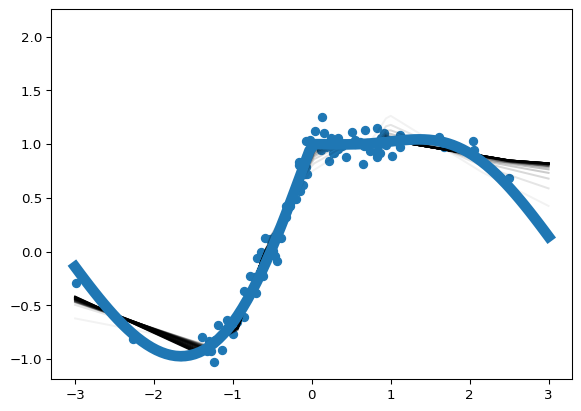

In [3]:
n = 100
sigma = 0.1
torch.manual_seed(987)
x = torch.randn(n,1)
f = np.vectorize(lambda x:  np.sin(x)+np.exp(-x*x)/(1+np.abs(x)))
y = torch.tensor(f(x), dtype=torch.float32) + sigma*torch.randn(x.shape)
slp = SingleLayerPerceptron(1, 20, nn.ReLU())
lossfn = nn.MSELoss()
xlin = torch.linspace(-3,3,100)
fig, ax = plt.subplots()
epochs = 1000
stepscale = 0.1
for i in range(epochs):
    if (i % 50) == 0 :
        ax.plot(xlin,slp(xlin.reshape(-1,1)).data, alpha=i/epochs, color='k')
        slp.zero_grad()
    loss = lossfn(y.flatten(),slp(x))
    #print(f"{i}: {loss.item()}")
    # calculate gradient
    loss.backward()
    # access gradient & use to descend
    for p in slp.parameters():
        if p.requires_grad:
            p.data = p.data - stepscale*p.grad.data
            p.grad.data.zero_()
    slp.zero_grad()

ax.plot(xlin, f(xlin), label="f", lw=8)
ax.scatter(x.flatten(),y.flatten())
fig.show()

## Multi Layer Perceptron

In [4]:
def multilayer(d,width,depth,activation=nn.ReLU()):
    mlp = nn.Sequential(
        nn.Linear(d,width),
        activation
    )
    for i in range(depth-1):
        mlp.add_module(f"layer {i+1}",nn.Linear(width, width))
        mlp.add_module(f"activation {i+1}",activation)


    mlp.add_module("output",nn.Linear(width,1))
    return(mlp)

mlp=multilayer(2, 10, 1, nn.ReLU())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Multi Layer Perceptron

73

/tmp/ipykernel_681713/1192107855.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


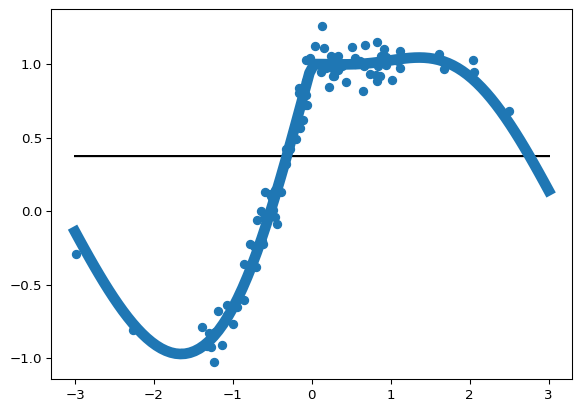

In [5]:
mlp = multilayer(1,4,4,nn.ReLU())
print(count_parameters(mlp))
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
fig, ax = plt.subplots()
epochs = 1000
for i in range(epochs):
    if (i % 50) == 0 :
        ax.plot(xlin,mlp(xlin.reshape(-1,1)).data, alpha=i/epochs, color='k')
        mlp.zero_grad()
    loss = lossfn(y,mlp(x))
    #print(f"{i}: {loss.item()}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

ax.plot(xlin, f(xlin), label="f", lw=8)
ax.scatter(x.flatten(),y.flatten())
fig.show()

# Double Descent and Overparameterization

## Overparameterization

-   Classic statistics wisdom about nonparametric regression: as
    parameters increase:
    -   Bias decreases
    -   Variance increases
    -   Need parameters $<$ sample size for good performance
-   Neural networks: often see best performance when parameters $>$
    sample size

## Double Descent

In [6]:
from joblib import Parallel, delayed
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # problem is small, so not much help from cuda
num_epochs = 50
sims = 100
maxw = 10

def doubledescentdemo(x, y, xtest, ytest, f, device=device,
                      num_epochs=num_epochs, sims=sims,
                      maxw=maxw, lr=0.1):
    x=x.to(device)
    y=y.to(device).reshape(x.shape[0],1)
    fx = f(x.T).reshape(y.shape).to(device)
    ytest = ytest.to(device).reshape(xtest.shape[0],1)
    xtest = xtest.to(device)
    loss_fn = nn.MSELoss().to(device)

    losses = np.zeros([maxw,num_epochs,sims])
    nonoise = np.zeros([maxw,num_epochs,sims])

    def dd(w):
        mlp = multilayer(x.shape[1],w+1,1,nn.ReLU()).to(device)
        optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
        losses = np.zeros(num_epochs)
        nonoise=np.zeros(num_epochs)
        for n in range(num_epochs):
            y_pred = mlp(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses[n] = loss_fn(mlp(xtest),ytest).item()
            nonoise[n] = loss_fn(y_pred, fx)
            mlp.zero_grad()
        return([losses, nonoise])

    for w in range(maxw):
        foo=lambda s: dd(w)
        print(f"width {w}")
        results = Parallel(n_jobs=20)(delayed(foo)(s) for s in range(sims))

        for s in range(sims):
            losses[w,:,s] = results[s][0]
            nonoise[w,:,s] = results[s][1]
    return([losses, nonoise])

## Double Descent

In [7]:
f = lambda x: np.exp(x[0]-x[1])
n = 20
torch.manual_seed(1234)
dimx = 5
x = torch.rand(n,dimx)
xtest = torch.rand(n,dimx)
sigma = 1.5
y = f(x.T) + sigma*torch.randn(x.shape[0])
ytest = f(xtest.T) + sigma*torch.randn(xtest.shape[0])
lr = 0.01
dd = doubledescentdemo(x, y, xtest, ytest, f, lr)

width 0
width 1
width 2
width 3
width 4
width 5
width 6
width 7
width 8
width 9

## Double Descent

/tmp/ipykernel_681713/3674602720.py:30: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


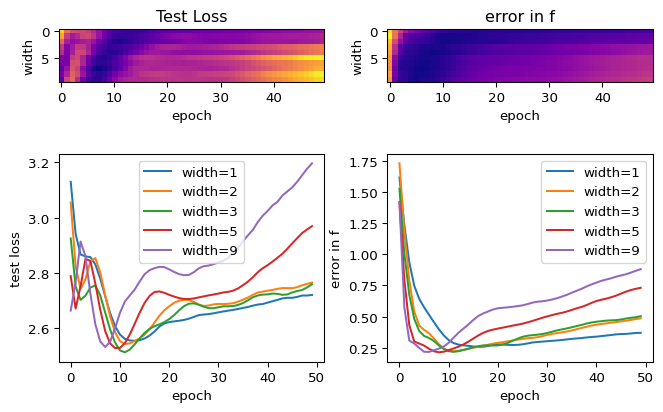

In [8]:
def plotdd(losses, nonoise):
    fig, ax = plt.subplots(2,2)
    ax = ax.flatten()
    ax[0].imshow(losses, cmap='plasma')
    ax[0].set_title('Test Loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('width')
    ax[1].imshow(nonoise, cmap='plasma')
    ax[1].set_title('error in f')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('width')

    ws = [0,1, 2, 4, 8]  #10, 12, 19]
    for w in ws:
        ax[2].plot(range(losses.shape[1]),losses[w,:], label=f"width={w+1}")
        ax[3].plot(range(nonoise.shape[1]),nonoise[w,:], label=f"width={w+1}")

    ax[2].set_xlabel('epoch')
    ax[2].set_ylabel('test loss')
    ax[2].legend()
    ax[3].set_xlabel('epoch')
    ax[3].set_ylabel('error in f')
    ax[3].legend()

    fig.tight_layout()

    return(fig)

fig=plotdd(dd[0].mean(axis=2), dd[1].mean(axis=2))
fig.show()

## Double Descent: Low Noise

In [9]:
sigma = 0.01
y = f(x.T) + sigma*torch.randn(x.shape[0])
ytest = f(xtest.T) + sigma*torch.randn(xtest.shape[0])
ddlowsig = doubledescentdemo(x,y,xtest,ytest,f, lr=0.05)

width 0
width 1
width 2
width 3
width 4
width 5
width 6
width 7
width 8
width 9

## Double Descent: Low Noise

/tmp/ipykernel_681713/1806854767.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


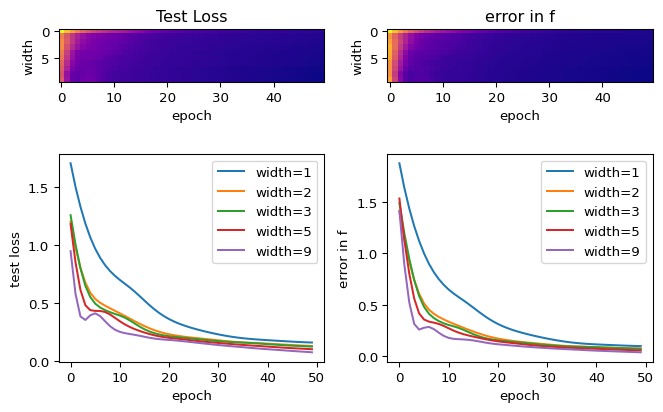

In [10]:
fig=plotdd(ddlowsig[0].mean(axis=2), ddlowsig[1].mean(axis=2))
fig.show()

## Double Descent

-   Figures show double descent in number of epochs, but has also been
    demonstrated with respect to number of parameters[1]
-   These simulations are quite fragile and depend on:
    -   Form of $f$
    -   dimension of $x$
    -   noise in $y$
    -   learning rate
    -   optimizer

# Software

## Software

-   PyTorch
    -   Used above
    -   Very popular
    -   Middle ground between convenience and flexibility
    -   Could be used via higher level wrapper
        (e.g. [skorch](https://github.com/skorch-dev/skorch))
-   [JAX](https://github.com/google/jax)
    -   More extensible than pytorch
-   Others: Tensorflow, Theano, Keras, and more

# Uses for Neural Networks

## Uses for Neural Networks

-   Flexible regression and/or classification method, in double/debiased
    learning or elsewhere
    -   Consider carefully whether difficulties of fitting are worth
        benefits
-   Flexible function approximation
    -   Useful for computing solutions to games, dynamic models, etc
-   Text, images, audio
    -   Use transfer learning

## Transfer Learning

-   Fit (or let researchers or company with more resources fit) large
    model on large, general dataset
-   Find specialized data for your task
-   Fine tune: take large model and update parameters with your data
-   <https://huggingface.co/> good source for large models to fine-tune

## Other Architectures

-   Multi-layer perceptrons / feed forward networks are the simplest
    neural networks, many extensions and variations exist
-   Tricks to help with vanishing gradients and numeric stability:
    -   Normalization
    -   Residual connections
-   Variations motivated by sequential data:
    -   Recurrent
    -   Transformers
-   Variations motivated by images:
    -   Convolutions
    -   GAN
    -   Diffusion[2]

## Sources and Further Reading

-   [QuantEcon Datascience: Regression - Neural
    Networks](https://datascience.quantecon.org/tools/regression.html#neural-networks)

-   [QuantEcon: Intro to Artificial Neural
    Nets](https://python.quantecon.org/back_prop.html)

-   [pytorch notebooks from
    323](https://github.com/ubcecon/ECON323_2021_Fall/tree/master/extra_notebooks)

## References

[1] If you squint, you can sort of see double descent in parameters in
these simulations too.

[2] The motivating idea of diffusion models is different than neural
networks, but neural networks are commonly used as one of the parts of
diffusion models.